In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Import required library

In [15]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 39.4 MB/s 
     |████████████████████████████████| 106 kB 49.9 MB/s 


In [16]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot,pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix

Read dataset and do pre-processing

In [49]:
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding = "ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Removing unwanted attributes

In [52]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [53]:
df.columns=["Category","Message"]
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [54]:
df["Message Length"]=df["Message"].apply(len)
df

,Category,Message,Message Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [56]:
df.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


Visualization of count of words

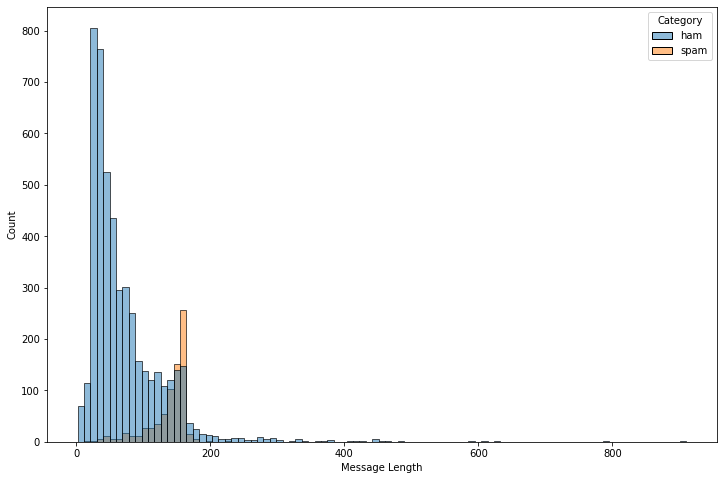

In [55]:
fig=plt.figure(figsize=(12,8))
sns.histplot(x=df["Message Length"],hue=df["Category"])
plt.show()

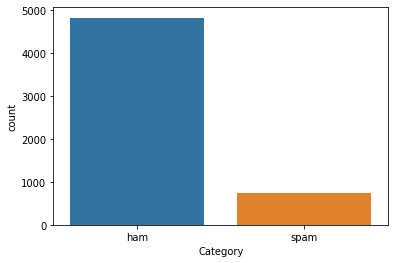

In [57]:
sns.countplot(df['Category'])

## Pre-processing texts

In [58]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [59]:
stemmer=PorterStemmer()
corpus=[]
for message in df["Message"]:
    message=re.sub("[^a-zA-Z]"," ",message)
    message=message.lower()
    message=message.split()
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    message=" ".join(message)
    corpus.append(message)

In [60]:
vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size) for words in corpus]

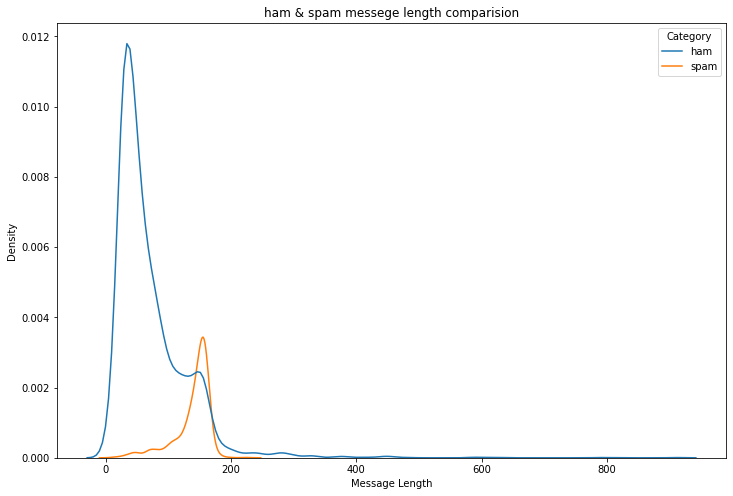

In [61]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [62]:
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Category"]

In [63]:
df_final=pd.concat([extract_features,target],axis=1)
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Category
0,0,0,0,0,0,0,0,0,0,0,...,8910,4925,7955,5222,4007,7499,3034,9618,8930,ham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9701,7076,3935,3176,9642,5358,ham
2,0,0,0,0,0,0,0,0,0,0,...,5741,6479,1721,5570,4353,9203,9935,6012,6931,spam
3,0,0,0,0,0,0,0,0,0,0,...,9642,3773,5772,9936,8559,9642,6012,5033,5772,ham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,5187,3731,7427,702,735,7737,8303,ham


In [64]:
vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size) for words in corpus]

In [65]:
sentence_len=200
embedded_doc=pad_sequences(oneHot_doc,maxlen=sentence_len,padding="pre")

In [66]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df['Label']

In [75]:
df_final=pd.concat([extract_features,target],axis=1)
df_final

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,8910,4925,7955,5222,4007,7499,3034,9618,8930,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9701,7076,3935,3176,9642,5358,0
2,0,0,0,0,0,0,0,0,0,0,...,5741,6479,1721,5570,4353,9203,9935,6012,6931,1
3,0,0,0,0,0,0,0,0,0,0,...,9642,3773,5772,9936,8559,9642,6012,5033,5772,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,5187,3731,7427,702,735,7737,8303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,3599,2642,2956,2277,8467,9279,4460,8461,9935,1
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9120,5765,3622,6305,2189,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5225,7351,8986,0
5570,0,0,0,0,0,0,0,0,0,0,...,5553,9443,7160,5858,557,3859,6289,9814,3805,0


In [87]:
X=df_final.drop(["Label"],axis=1)
y=df_final["Label"]

## Splitting the dataset 

In [88]:
X_trainval,X_test,y_trainval,y_test=train_test_split(X,y,random_state=42,test_size=0.15)
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval,random_state=42,test_size=0.15)

## Creating the model, Adding the layers and Compiling the model

In [89]:
model=Sequential()
feature_num=100
model.add(Embedding(input_dim=vocab_size, output_dim=feature_num,input_length=sentence_len))
model.add(LSTM(units=128))
model.add(Dense(units=1,activation="sigmoid"))
model.add(Flatten())
model.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

### Fit the Model

In [90]:
model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=10)

Epoch 1/10
126/126 [==============================] - 9s 19ms/step - loss: 0.1640 - accuracy: 0.9483 - val_loss: 0.0812 - val_accuracy: 0.9733
Epoch 2/10
126/126 [==============================] - 2s 15ms/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0700 - val_accuracy: 0.9831
Epoch 3/10
126/126 [==============================] - 2s 15ms/step - loss: 0.0149 - accuracy: 0.9965 - val_loss: 0.0683 - val_accuracy: 0.9845
Epoch 4/10
126/126 [==============================] - 2s 15ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0781 - val_accuracy: 0.9845
Epoch 5/10
126/126 [==============================] - 2s 15ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0879 - val_accuracy: 0.9845
Epoch 6/10
126/126 [==============================] - 2s 15ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0819 - val_accuracy: 0.9859
Epoch 7/10
126/126 [==============================] - 2s 15ms/step - loss: 9.4581e-04 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.

In [94]:
y_pred=model.predict(X_test)

27/27 [==============================] - 0s 10ms/step


In [93]:
score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:98.68%
